In [41]:
import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint

## Config

In [42]:
PROJECT_ROOT = os.path.abspath("..")

DATA_DIR = os.path.join(PROJECT_ROOT, "data/Rice_Leaf_AUG")
BASELINE_DIR = os.path.join(PROJECT_ROOT, "models/baseline/mobilenetv2_rice")
INFERENCE_DIR = os.path.join(PROJECT_ROOT, "models/baseline/mobilenetv2_rice_infer/baseline_best.keras")

os.makedirs(BASELINE_DIR, exist_ok=True)

In [43]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS_BASELINE = 20
EPOCHS_FINETUNE = 10

NUM_CLASSES = 6
LR_BASELINE = 1e-3
LR_FINETUNE = 1e-4
SEED = 42


## Data Splitting

In [44]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(class_names)


Found 3829 files belonging to 6 classes.
Using 3064 files for training.
Found 3829 files belonging to 6 classes.
Using 765 files for validation.
['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Sheath Blight']


## Data augmentation (for training only)

In [45]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x, training=True), y

train_ds_aug = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_aug = train_ds_aug.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Training (base model)

In [49]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_BASELINE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [50]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=INFERENCE_DIR,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]


history_baseline = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS_BASELINE,
    callbacks=callbacks
)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3791 - loss: 1.6330
Epoch 1: val_accuracy improved from -inf to 0.63268, saving model to models/baseline_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 0.3802 - loss: 1.6298 - val_accuracy: 0.6327 - val_loss: 0.9477
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6526 - loss: 0.9199
Epoch 2: val_accuracy improved from 0.63268 to 0.72288, saving model to models/baseline_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.6526 - loss: 0.9197 - val_accuracy: 0.7229 - val_loss: 0.8021
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7061 - loss: 0.7965
Epoch 3: val_accuracy improved from 0.72288 to 0.75163, saving model to models/baseline_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.7061 - loss: 0.7965 - val_accuracy: 0.7516 - val_loss: 0.7170
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7219 - loss: 0.7422
Epoch 4:

## Evaluate (base model)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.72      0.76      0.74       109
           Brown Spot       0.83      0.82      0.82       139
    Healthy Rice Leaf       0.98      0.98      0.98       133
           Leaf Blast       0.57      0.71      0.63       111
           Leaf scald       0.81      0.72      0.76       137
        Sheath Blight       0.95      0.83      0.89       136

             accuracy                           0.81       765
            macro avg       0.81      0.80      0.80       765
         weighted avg       0.82      0.81      0.81       765



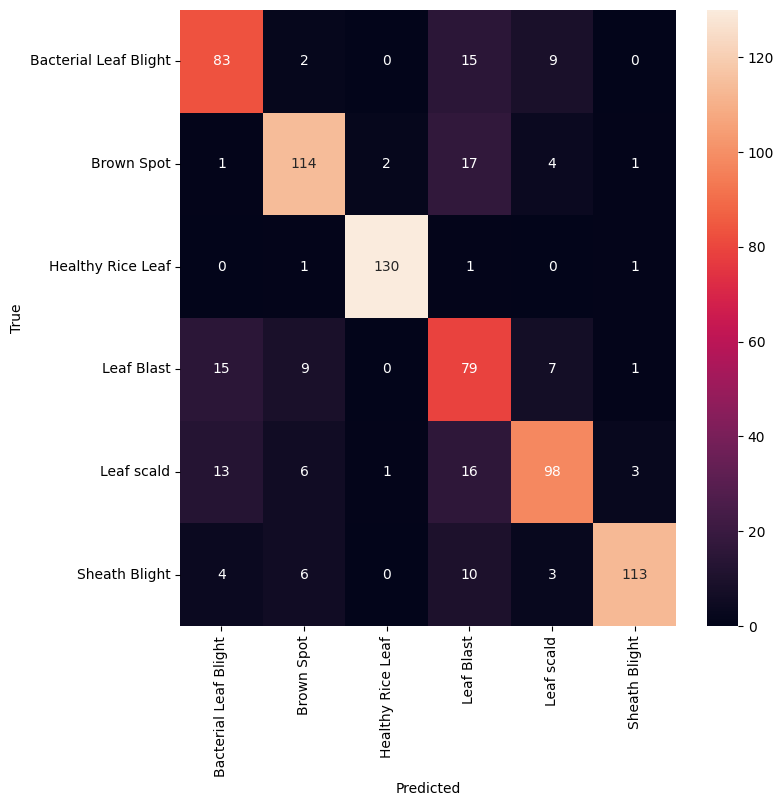

In [51]:
val_images = []
val_labels = []

for x, y in val_ds:
    val_images.append(x)
    val_labels.append(y)

val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

preds = model.predict(val_images)
y_pred = np.argmax(preds, axis=1)

print(classification_report(val_labels, y_pred, target_names=class_names))

cm = confusion_matrix(val_labels, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Finetuning

In [52]:
base_model.trainable = True

for layer in base_model.layers[:-80]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_FINETUNE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE,
    callbacks=callbacks
)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6190 - loss: 1.1101
Epoch 1: val_accuracy did not improve from 0.80654
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 251ms/step - accuracy: 0.6199 - loss: 1.1070 - val_accuracy: 0.5922 - val_loss: 2.1221
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8216 - loss: 0.4776
Epoch 2: val_accuracy did not improve from 0.80654
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.8218 - loss: 0.4773 - val_accuracy: 0.5752 - val_loss: 2.1873
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8886 - loss: 0.3335
Epoch 3: val_accuracy did not improve from 0.80654
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.8887 - loss: 0.3332 - val_accuracy: 0.5817 - val_loss: 2.0868
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9310 - loss: 0.2041
Epoch 4: val_accuracy did not improve from 0.80654
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.9310 - loss: 0.2042 - val_accuracy: 0.6065

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.68      0.91      0.78       109
           Brown Spot       0.84      0.92      0.88       139
    Healthy Rice Leaf       0.87      1.00      0.93       133
           Leaf Blast       0.68      0.84      0.75       111
           Leaf scald       0.85      0.77      0.81       137
        Sheath Blight       1.00      0.39      0.56       136

             accuracy                           0.80       765
            macro avg       0.82      0.81      0.78       765
         weighted avg       0.83      0.80      0.79       765



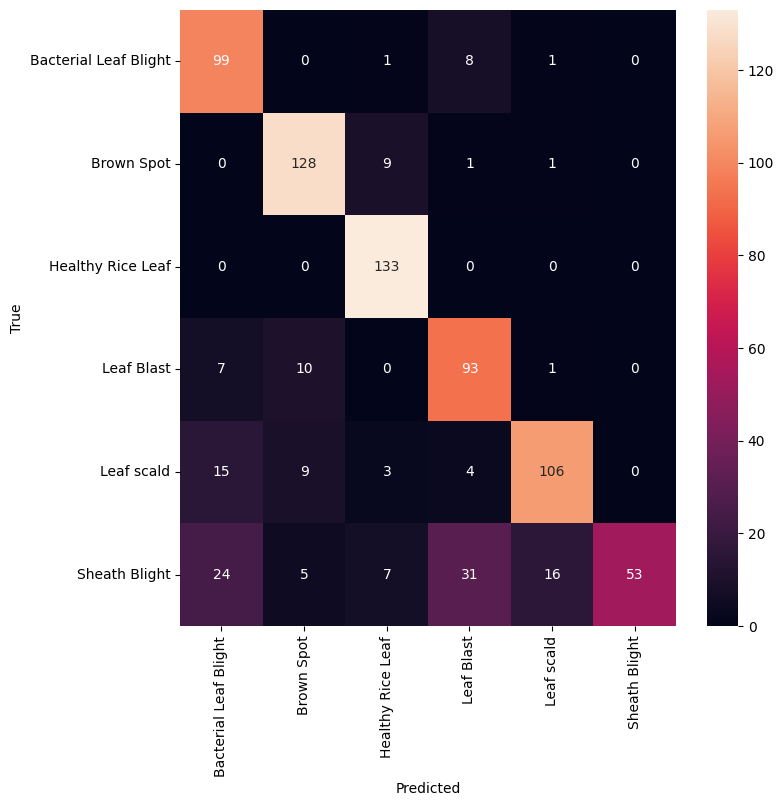

In [53]:
preds = model.predict(val_images)
y_pred = np.argmax(preds, axis=1)

print(classification_report(val_labels, y_pred, target_names=class_names))

cm = confusion_matrix(val_labels, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Load Best Model

In [56]:
best_model = tf.keras.models.load_model("models/baseline_best.keras")

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.72      0.76      0.74       109
           Brown Spot       0.83      0.82      0.82       139
    Healthy Rice Leaf       0.98      0.98      0.98       133
           Leaf Blast       0.57      0.71      0.63       111
           Leaf scald       0.81      0.72      0.76       137
        Sheath Blight       0.95      0.83      0.89       136

             accuracy                           0.81       765
            macro avg       0.81      0.80      0.80       765
         weighted avg       0.82      0.81      0.81       765



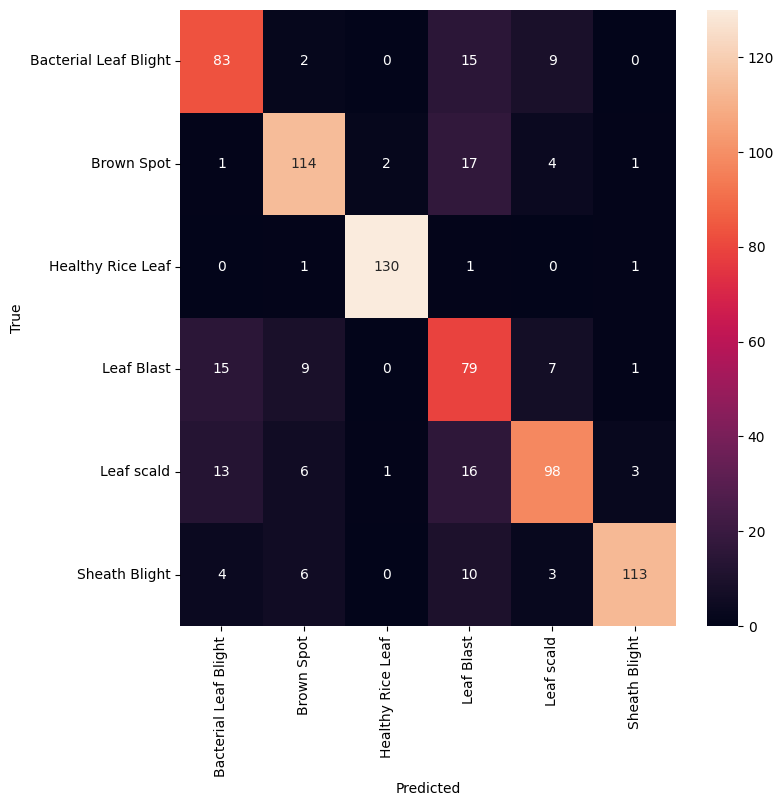

In [58]:
preds = best_model.predict(val_images)
y_pred = np.argmax(preds, axis=1)

print(classification_report(val_labels, y_pred, target_names=class_names))

cm = confusion_matrix(val_labels, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Model Export


In [59]:
model.export(BASELINE_DIR)
print("Saved baseline model to:", BASELINE_DIR)

INFO:tensorflow:Assets written to: /Users/macbook/Desktop/rice-disease-edge-ai/models/baseline/mobilenetv2_rice/assets


INFO:tensorflow:Assets written to: /Users/macbook/Desktop/rice-disease-edge-ai/models/baseline/mobilenetv2_rice/assets


Saved artifact at '/Users/macbook/Desktop/rice-disease-edge-ai/models/baseline/mobilenetv2_rice'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_650')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  11028859712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11028935072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11028935248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11028860240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11028860064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11028938064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11028983872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11028984928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11028969952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11028971360: TensorSpec(shape=(), dtype=tf.resource, nam

In [60]:
PROJECT_ROOT = os.path.abspath("..")
MODEL_DIR = BASELINE_DIR = os.path.join(PROJECT_ROOT, "models/baseline/mobilenetv2_rice_infer/baseline_best.keras")

model = tf.keras.models.load_model(
    MODEL_DIR,
)